In [1]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import theano as T
import theano.tensor as tt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

import copy


import pymc3 as pm
import scipy as sp
import scipy.stats as stats

import cv2
import cw_utils

['dot', '-Tps', '/var/folders/3s/j7n5q0y13s50l2xccn51fnph0000gn/T/tmpp36_txea'] return code: 1

stdout, stderr:
 b''
b'Format: "ps" not recognized. Use one of:\n'



In [2]:
data_csvs = {}
path = './../data/test_data/'
names = [
    "test1-2017-11-03T09-31.csv",
    "test2-2017-11-08T09-19.csv",
    "test3-2017-11-09T09-23.csv",
    "test4-2017-11-10T09-24.csv",
    "test5-2017-11-16T11-41.csv"
]
data_csvs['df_1'] = pd.read_csv(path+ names[0]).iloc[6:]
data_csvs['df_2'] = pd.read_csv(path+ names[1]).iloc[6:]
data_csvs['df_3'] = pd.read_csv(path+ names[2]).iloc[6:]
data_csvs['df_4'] = pd.read_csv(path+ names[3]).iloc[6:]
data_csvs['df_5'] = pd.read_csv(path+ names[4]).iloc[6:]

for k,v in data_csvs.items():
    
    data_csvs[k].columns = data_csvs[k].columns.str.strip()
    data_csvs[k] = data_csvs[k][['Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]
    data_csvs[k]['Other_Water'] = 2.5-data_csvs[k].sum(axis=1)
    data_csvs[k] = data_csvs[k] / 2.5
    data_csvs[k] = data_csvs[k][['Other_Water', 'Desert_Water', 'Jungle_Water', 'Wetlands_Water', 'Plains_Water']]

data_csvs['df_2'].head(2)

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Other_Water,Desert_Water,Jungle_Water,Wetlands_Water,Plains_Water
6,1.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0


### Convert the .mov files for easier viewing

In [3]:
# don't run this if not necessary
# for f_name in names:
    
#     print(f_name)
#     mov_name = f_name.replace('.csv', '.mov')
#     cw_utils.get_mini_view_video(path + mov_name, path + f_name)

# Run State-Estimation to Find Params

Useful

In [4]:
def plot_log_positions(df_name, results):
    # for each split in found splits
    video_name = names[int(df_name.split('_')[1])-1]
    print(video_name)
    video_name = video_name.replace('.csv', '.mov')
    for time_split in results[df_name]['breaks']:

        if time_split not in [0, len(data_csvs[df_name].values)]:

            min_ = time_split // 60
            sec_ = time_split - (min_ * 60)

            print("Split %i:%02d min" % (min_, sec_))
            print("Logs leading into Split")
            fig, axes = plt.subplots(1,4, figsize=(15,4))
            for i, ax in enumerate(axes):

                ts = time_split - (8-2*i)
                min_ = ts // 60
                sec_ = ts - (min_ * 60)

                ax.set_title("Split %i:%02d min" % (min_, sec_))

                cap = cv2.VideoCapture(path + video_name)
                cap.set(1,ts)
                ret, frame = cap.read()

                ax.set_aspect('equal')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                ax.imshow(frame[864:1080,0:384])
            plt.show()

            print("Logs after split")
            fig, axes = plt.subplots(1,4, figsize=(15,4))
            for i, ax in enumerate(axes):

                ts = time_split + 2*(i)
                min_ = ts // 60
                sec_ = ts - (min_ * 60)

                ax.set_title("Split %i:%02d min" % (min_, sec_))

                cap = cv2.VideoCapture(path + video_name)
                cap.set(1,ts)
                ret, frame = cap.read()

                ax.set_aspect('equal')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                ax.imshow(frame[864:1080,0:384])
            plt.show()

            print('--------------------------------------------------------')
            print('--------------------------------------------------------')
            print()
            
results = {}

In [5]:
mu0 = np.ones(5)/5
Sig0 = np.eye(5)*1
Phi = np.eye(5)
Q = np.eye(5)*1e-3
R = np.eye(5)*1e-8
N = 5

params = {"mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R,
           "A": np.eye(N)}

### Test 1

In [6]:
df_name = 'df_1'

if df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values,
                                       num_breaks=6,
                                       starting_params=params,
                                       percentage=90)
    results[df_name] = em_res

[  0  64 128 192 256 320 387]
3
[  0 154  25  75 387]
SVD Converge Caught 4
[  0  96 192 288 387]
1
[  0  29 387]
0
[  6 387]
[  0 387]
Converged


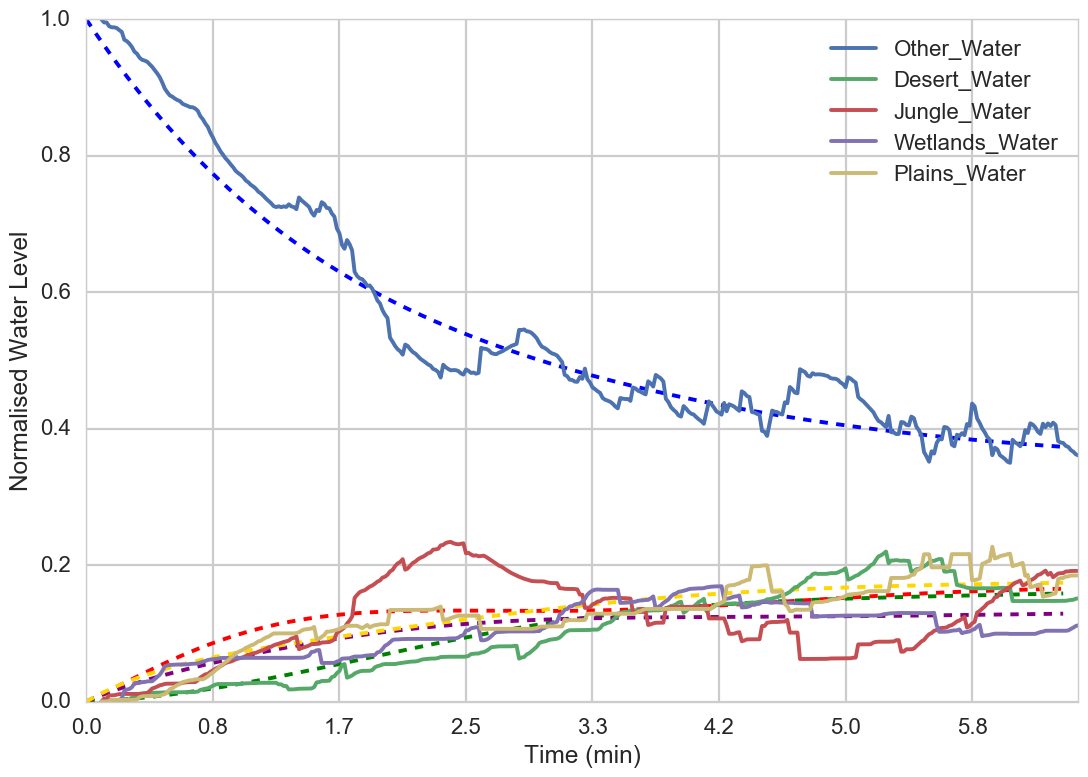

In [7]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

In [8]:
df_name = 'df_1'            
plot_log_positions(df_name=df_name, results=results)

test1-2017-11-03T09-31.csv


**Points of interest:**
- Lot's of water is directed to the plains in the first 1min 25.
- Switch-point detected at 1min:25 but large increase in Jungle Water only occurs at 1:35min.
- Starting at 2:18min water is piped out of the Jungle (correctly detected).
- There is a general trend of water toward the Desert that is hard to pinpoint to one specific action.
- Large increase in the amount of water to the jungle. Actions seem to come slightly after the switchpoint. 

<hr />
### Test 2

In [44]:
df_name = 'df_2'

if df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values,
                                       num_breaks=6,
                                       starting_params=params,
                                       percentage=88)
    results[df_name] = em_res

[  0  66 132 198 264 330 396]
SVD Converge Caught 5
[  0  79 158 237 316 396]
SVD Converge Caught 4
[  0  99 198 297 396]
SVD Converge Caught 3
[  0 132 264 396]
[  0 144 276 396]
[  0 148 271 396]
Converged


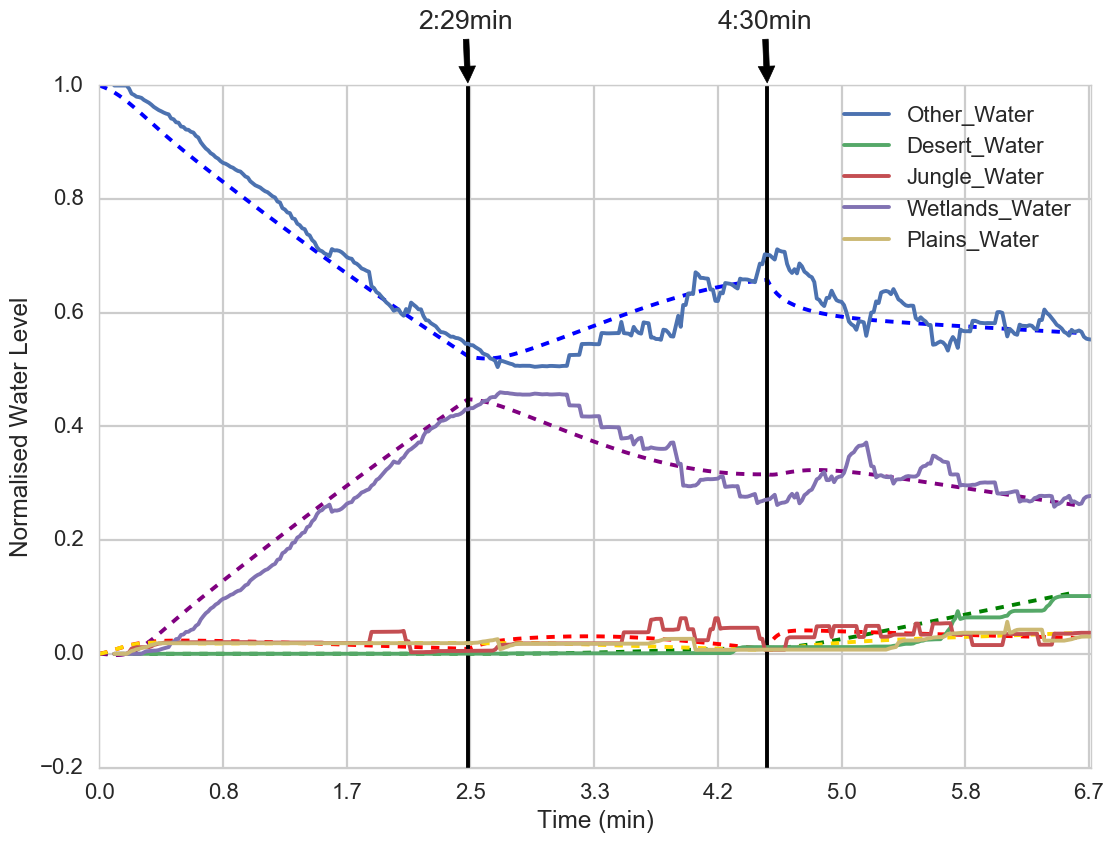

In [45]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

test2-2017-11-08T09-19.csv
Split 2:29 min
Logs leading into Split


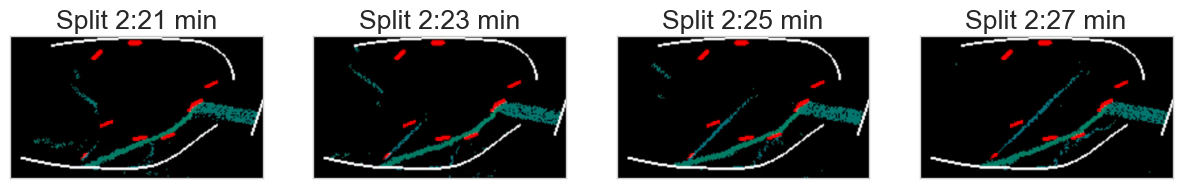

Logs after split


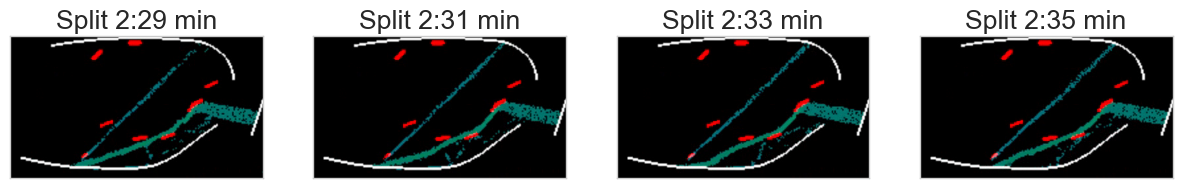

--------------------------------------------------------
--------------------------------------------------------

Split 4:30 min
Logs leading into Split


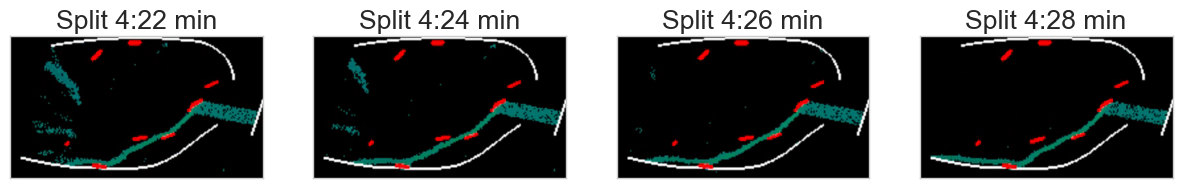

Logs after split


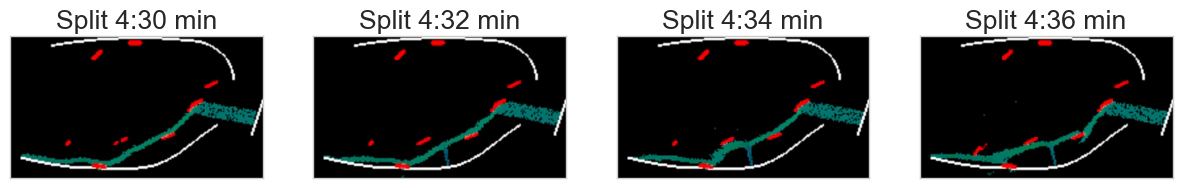

--------------------------------------------------------
--------------------------------------------------------



In [46]:
df_name = 'df_2'            
plot_log_positions(df_name=df_name, results=results)

**Points of interest:**
- Clear water being piped to wetlands for first 2min
- Starting time 2:18min water is piped away from wetlands and directed to Plains in minor amounts and back to the waterfall in major amounts. This is correctly detected.
- Starting 4:25min, the water is redirected back to wetlands in smaller amounts. The reservoir is used to pipe additional water into the system.
- Desert get additional water from the overflow of the reservoir. An interesting observation is that we are not detecting this as a switch in the system dynamics.

<hr />
### Test 3

In [47]:
df_name = 'df_3'
flag = False
if flag and df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values, num_breaks=6, starting_params=params, percentage=88)
    results[df_name] = em_res

[  0  66 132 198 264 330 396]
SVD Converge Caught 5
[  0  79 158 237 316 396]
SVD Converge Caught 4
[  0  99 198 297 396]
[  0  92 220 292 396]
SVD Converge Caught 3
[  0 132 264 396]
[  0 194 276 396]
SVD Converge Caught 2
[  0 198 396]
[  0 220 396]
[  0 229 396]
[  0 231 396]
[  0 235 396]
[  0 246 396]
[  0 267 396]
[  0 270 396]
Converged


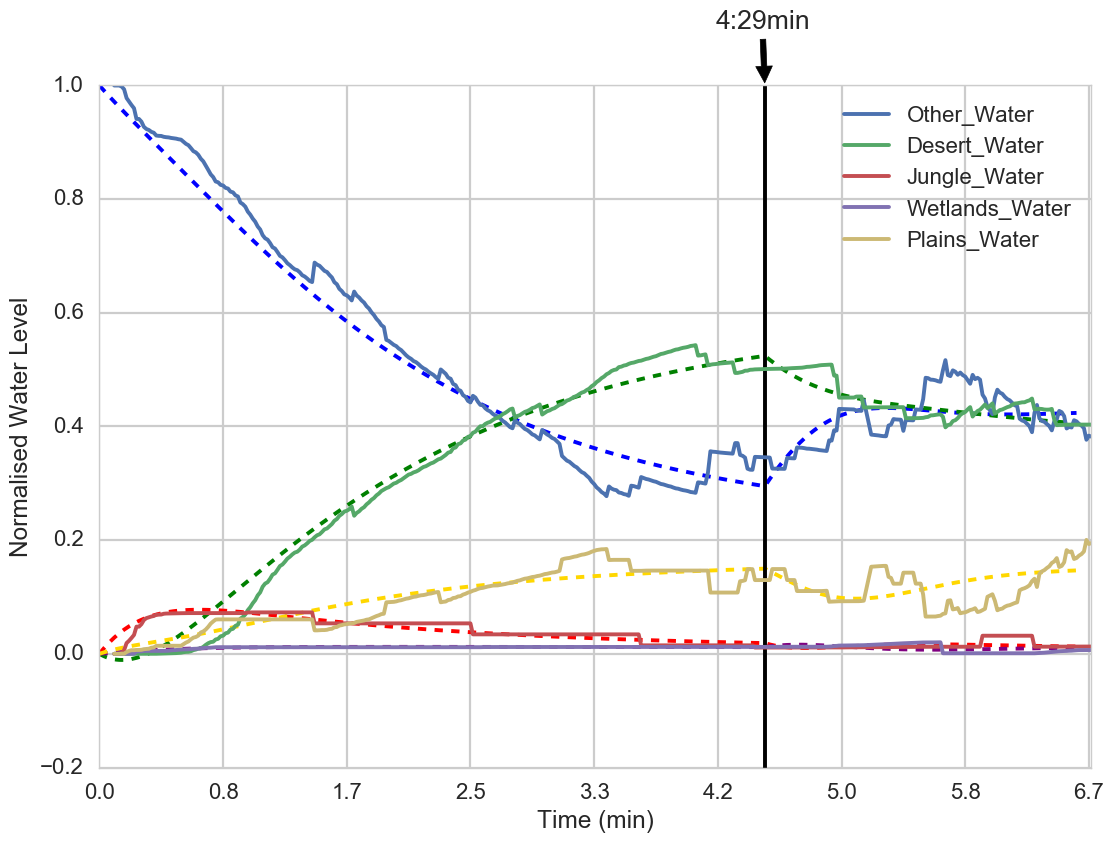

In [48]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

test3-2017-11-09T09-23.csv
Split 4:29 min
Logs leading into Split


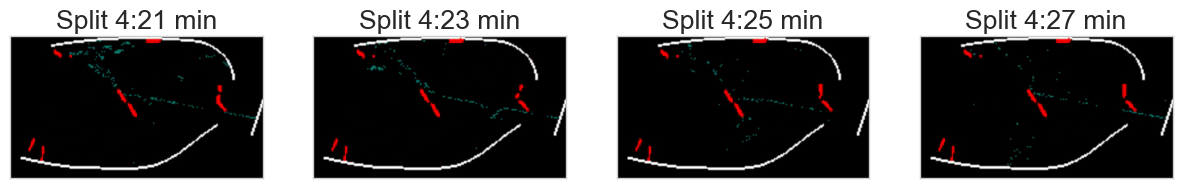

Logs after split


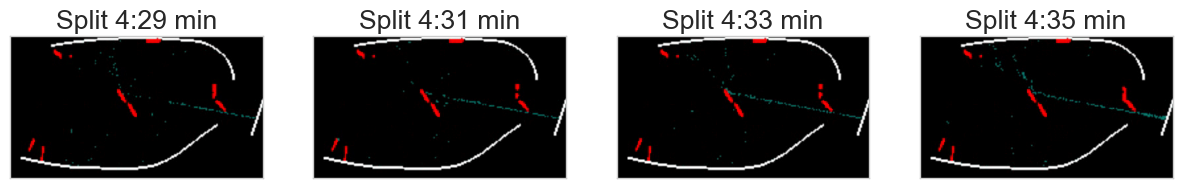

--------------------------------------------------------
--------------------------------------------------------



In [50]:
df_name = 'df_3'            
plot_log_positions(df_name=df_name, results=results)

**Points of interest:**
- Heavy water straight into Jungle is clear. That first change should possibly become a switch in future iterations.
- From 40sec to 4min:30 the water is heavily piped to Desert and is directed to Plains in a minor amount.
- Very interesting to notice that the model captures the decreasing rate in the flow of water as still one switch but then indicates a salient switch when the water actually runs out at 4min30.

<hr />
### Test 4

In [11]:
# df_name = 'df_4'

# if df_name in results:
#     em_res = results[df_name]
# else:
em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values, num_breaks=6, starting_params=params, percentage=80)
results[df_name] = em_res

[  0  65 130 195 260 325 391]
1
[  0 121 182 250 329 391]
[  0 119 177 244 328 391]
[  0 113 180 231 326 391]
[  0 107 179 224 325 391]
[  0  91 176 219 326 391]
2
[  0  73 204 324 391]
[  0  72 201 322 391]
[  0  73 195 325 391]
[  0  73 199 325 391]
[  0  74 203 327 391]
[  0  71 200 323 391]
[  0  73 192 325 391]
[  0  75 192 327 391]
[  0  73 194 327 391]


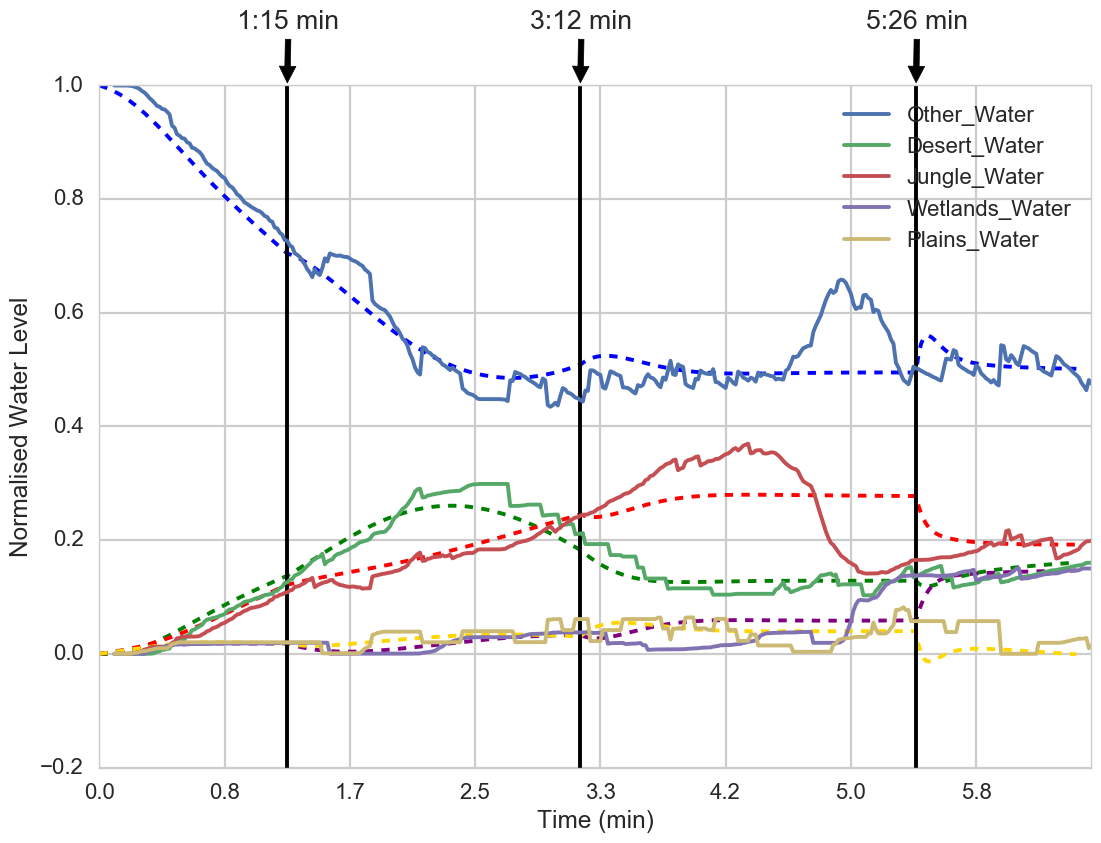

In [12]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

test4-2017-11-10T09-24.csv
Split 1:15 min
Logs leading into Split


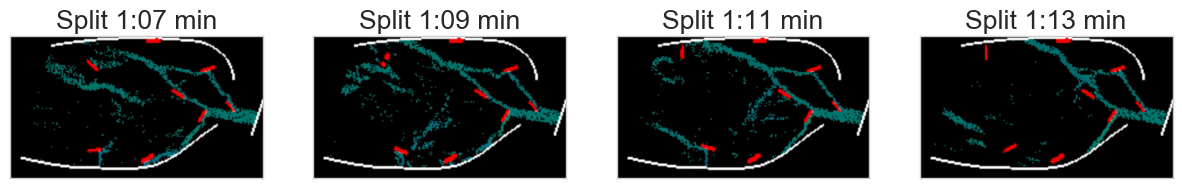

Logs after split


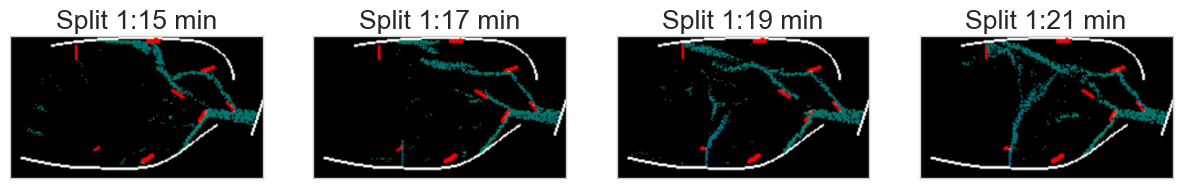

--------------------------------------------------------
--------------------------------------------------------

Split 3:12 min
Logs leading into Split


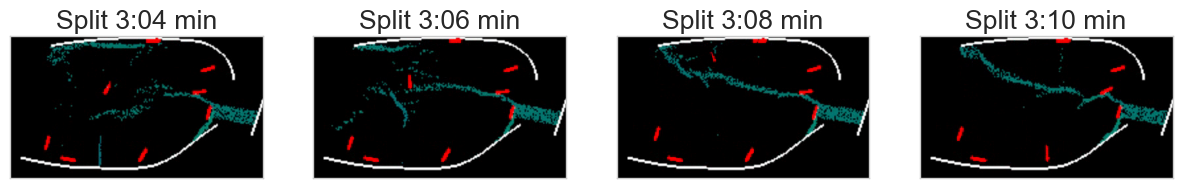

Logs after split


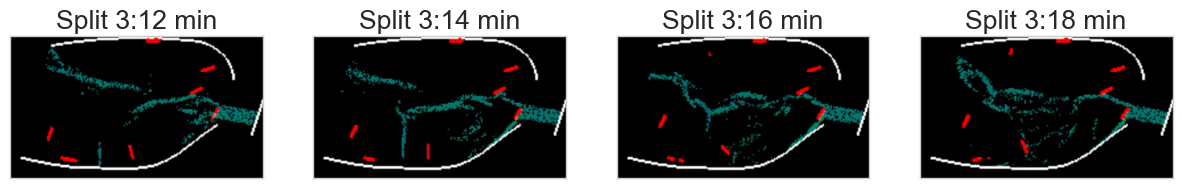

--------------------------------------------------------
--------------------------------------------------------

Split 5:26 min
Logs leading into Split


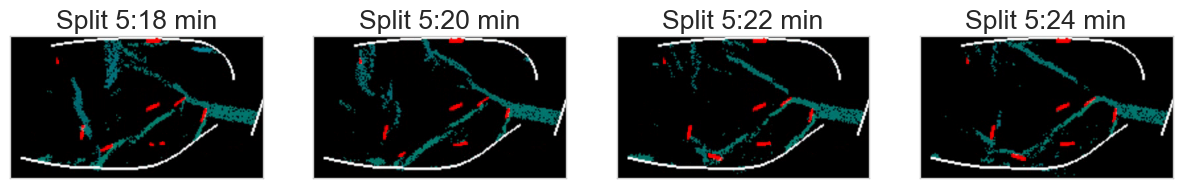

Logs after split


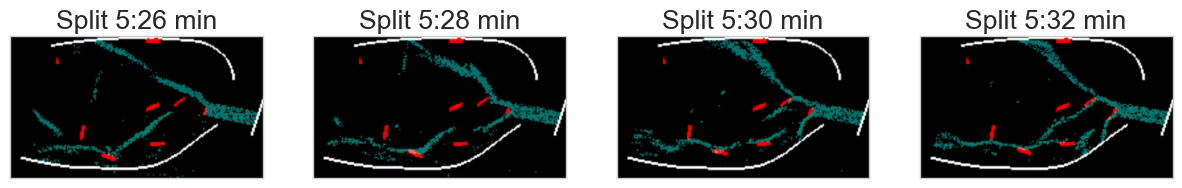

--------------------------------------------------------
--------------------------------------------------------



In [13]:
df_name = 'df_4'            
plot_log_positions(df_name=df_name, results=results)

**Points of interest:**
- The dynamics of the system are not captured well here.

<hr />
### Test 5

In [54]:
df_name = 'df_5'

if df_name in results:
    em_res = results[df_name]
else:
    em_res = cw_utils.learn_breakpoint(data_csvs[df_name].values, num_breaks=6, starting_params=params, percentage=90)
    results[df_name] = em_res

[  0  66 132 198 264 330 397]
[  0  62 125 209 258 344 397]
[  0  58 122 211 254 349 397]
3
[  0  53 116 250 352 397]
[  0  47 114 252 352 397]
[  0  40 110 254 353 397]
[  0  38 106 255 353 397]
[  0  37  98 259 354 397]
[  0  35  93 264 354 397]
[  0  30  93 261 354 397]
0
[ 27  95 264 355 397]
[  0  93 259 354 397]
[  0  97 263 355 397]
[  0  97 260 354 397]
[  0  97 264 355 397]
Converged


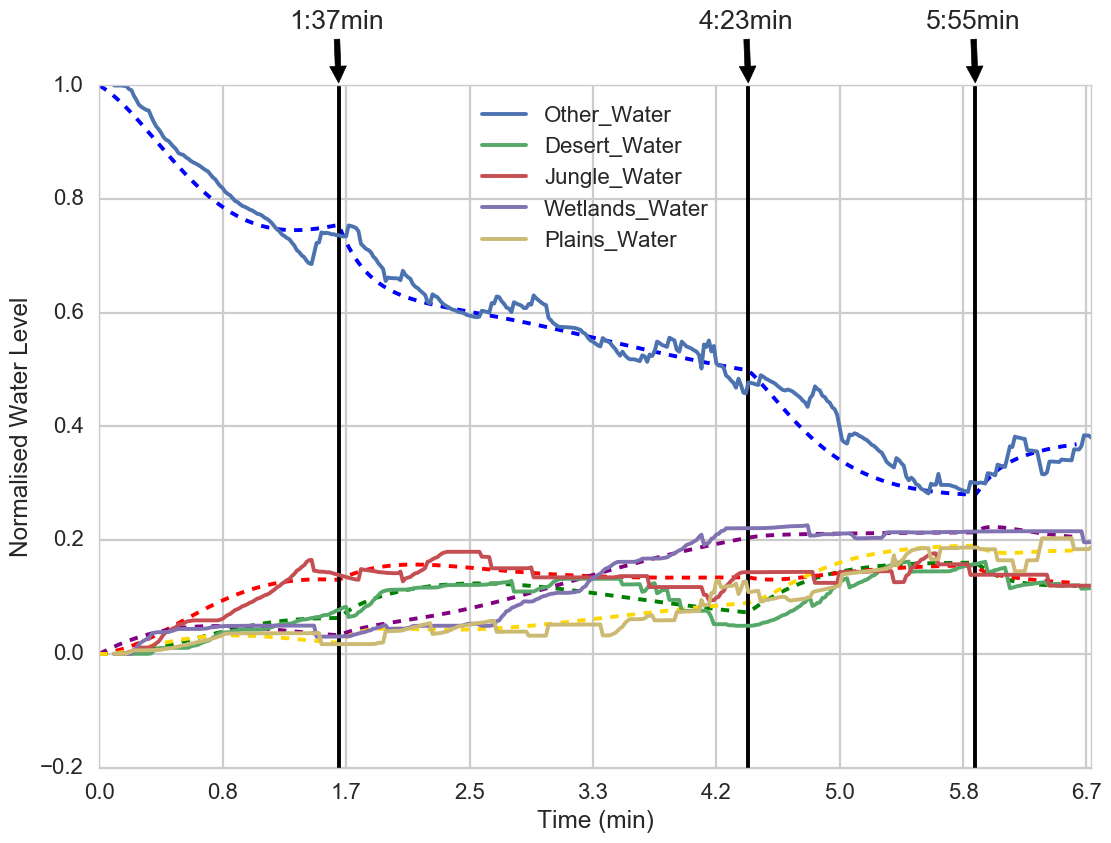

In [55]:
fig, ax = plt.subplots(1,1)
ax = cw_utils.plot_data_and_boundaries(df=data_csvs[df_name], em_results=em_res, ax=ax)
plt.show()

test5-2017-11-16T11-41.csv
Split 1:37 min
Logs leading into Split


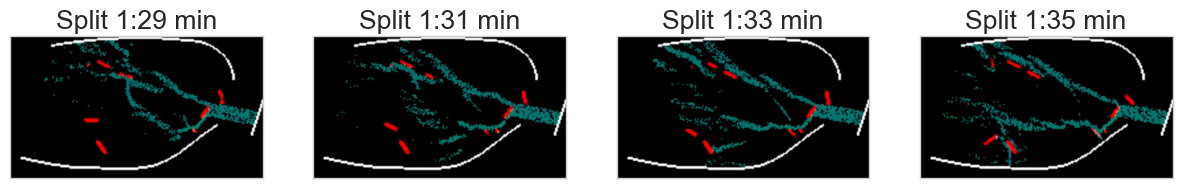

Logs after split


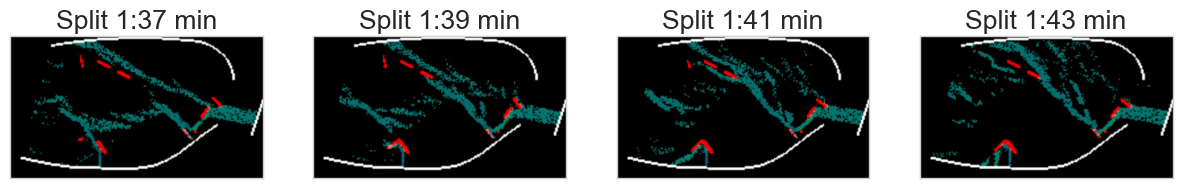

--------------------------------------------------------
--------------------------------------------------------

Split 4:23 min
Logs leading into Split


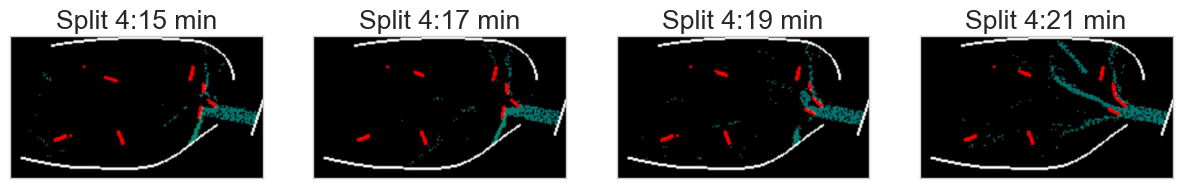

Logs after split


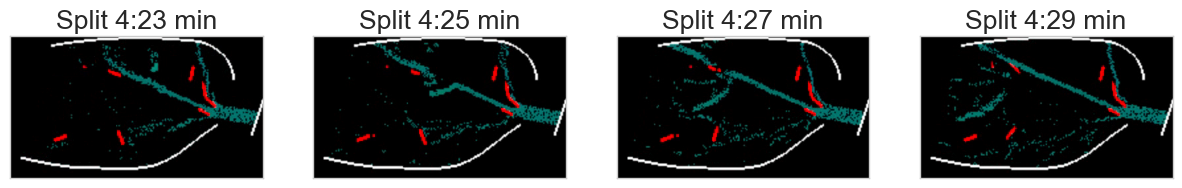

--------------------------------------------------------
--------------------------------------------------------

Split 5:55 min
Logs leading into Split


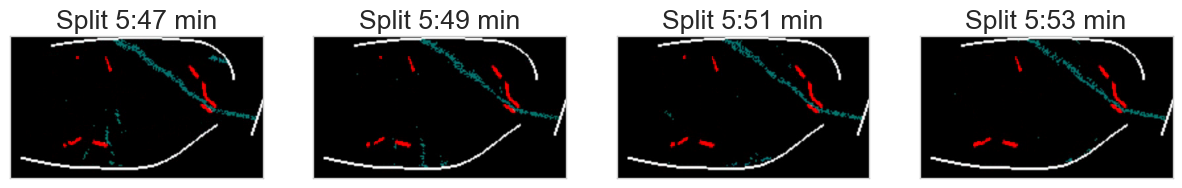

Logs after split


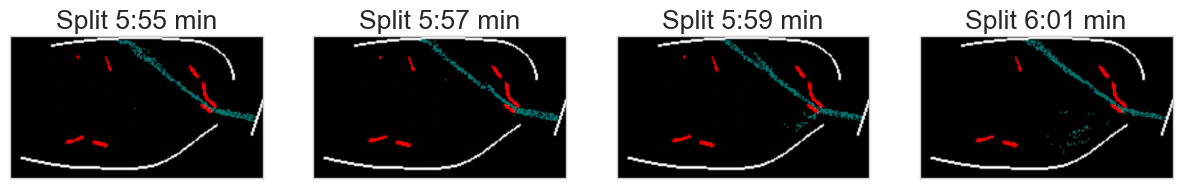

--------------------------------------------------------
--------------------------------------------------------



In [56]:
df_name = 'df_5'            
plot_log_positions(df_name=df_name, results=results)

**Points of interest:**
- Large increase in wetlands water and associated action can be found in video t~1:37min. Jungle levels off at this point.
- Plains and Desert get substantially more at second time step 4:23min.
- Large increase is other water at 5:55min. Where does this come from?